
# <center><font size="18" color='red'>CALIBRATION RUN</font></center> 

# Processing of triggerlessly acquired detector's data
## PREPROCESSING

Load and prepare the dataset inside a Pandas' DataFrame.

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from matplotlib.ticker import MultipleLocator
import seaborn as sns

%matplotlib inline

Inside each directory there are several files related to different test. Now we want to merge them into the same DataFrame.

In [62]:
# Load part of the dataset (all the dataset cause memory error, sometimes also more than two part can cause it)
# List all files inside the directory
directory = "/data/Run000260/"
file_names = [file for file in listdir(directory) if isfile(join(directory, file))]

# Create dataframe by appending the data from each file
data = pd.read_csv(directory + file_names[0])
# It's possible to increase the range for loading more data (up to len(file_names)=8)
for i in range(1, 2):
    data = data.append(pd.read_csv(directory + file_names[i]))
data = data.reset_index(drop=True)

In [63]:
## TEST ONLY
# Prepare the path to the file
##directory = "/data/Run000260/"
##file_name = "data_000000.txt"

# Load the dataset
##data = pd.read_csv(directory + file_name)

In [64]:
# Useful constants
Tmax = 390 # ns
L = 42 # mm
Vd = L/(2*Tmax) # mm/ns
pos_offset = 21 # mm

# Add column of time (ns)
# There is a problem with the precision of the measures, so we drop the orbit
# Real time: data['TIME_NS'] = data["ORBIT_CNT"]*3564*25 + data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30
data['TIME_NS'] = data["BX_COUNTER"]*25 + data["TDC_MEAS"]*25/30

# Show first 5 rows
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
0,1,0,126,1933476838,2034,26,50871.666667
1,1,0,123,1933476838,2037,9,50932.500000
2,1,0,124,1933476838,2037,18,50940.000000
3,1,1,54,1933476838,3224,27,80622.500000
4,1,1,115,1933476838,3230,3,80752.500000


To compute the constant $t_0$, which is different for every event, we can use the following relation:
$$T_{MAX}=\frac{t_{1}+t_{3}}{2}+t_{2}$$
where $t_1 = t_{R_1}-t_0$, $t_2 = t_{R_2}-t_0$ and $t_3 = t_{R_3}-t_0$. Then the relation become:
$$T_{MAX}=\frac{t_{R_1}-t_0+t_{R_3}-t_0}{2}+t_{R_2}-t_0$$
from which we get:
$$t_0=\frac{t_{R_1}+t_{R_3}+2t_{R_2}-2T_{MAX}}{4}$$
Finally we notice that $t_{R_1}$, $t_{R_2}$, $t_{R_3}$ are the times recorded by each cell, which are already available in our dataset.

Before processing the dataset, we have to create some missing columns, in fact the DataFrame with the events must contain the following information:
* CHAMBER, which is the Detector number [1-4];
* LAYER, which is the layer of the cell [1-4];
* CELL, which is in the number of the cell [1-16]; 
* POSTION, which is the position where a particle traverses the cell [0-21] (in mm). 

### Column of LAYER
To get the layer we can compute the remainder of the TDC_CHANNEL with 4 (total number of layers), and then we have to remap the values in the following way:

| REMAINDER | LAYER |
|-----------|-------|
| 0         | 1     |
| 1         | 4     |
| 2         | 2     |
| 3         | 3     |


In [65]:
# To get the layer we must get the remainder of the TDC_CHANNEL with 4
# Then we must reoder the result as described above
data['LAYER'] = data['TDC_CHANNEL'] % 4

# Map 1 --> 4
data.loc[data['LAYER'] == 1,'LAYER'] = 4

# Map 0 -> 1
data.loc[data['LAYER'] == 0,'LAYER'] = 1

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER
0,1,0,126,1933476838,2034,26,50871.666667,2
1,1,0,123,1933476838,2037,9,50932.500000,3
2,1,0,124,1933476838,2037,18,50940.000000,1
3,1,1,54,1933476838,3224,27,80622.500000,2
4,1,1,115,1933476838,3230,3,80752.500000,3


### Column of CHAMBER
Create the column for the chamber according to the following rules:
* Detector 1 $\rightarrow$ FPGA 0, TDC_CHANNEL in [1-64]
* Detector 2 $\rightarrow$ FPGA 0, TDC_CHANNEL in [65-128]
* Detector 3 $\rightarrow$ FPGA 1, TDC_CHANNEL in [1-64]
* Detector 4 $\rightarrow$ FPGA 1, TDC_CHANNEL in [65-128]


In [66]:
# Create column for chamber
# Before create empty column
data['CHAMBER'] = 0

# Detector 1
# Select all rows with FPGA = 0 and TDC_CHANNEL <= 64
data.loc[(data['FPGA'] == 0) & (data['TDC_CHANNEL'] <= 64),'CHAMBER'] = 1

# Detector 2
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
data.loc[(data['FPGA'] == 0) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128),'CHAMBER'] = 2

# Detector 3
# Select all rows with FPGA = 1 and TDC_CHANNEL <= 64
data.loc[(data['FPGA'] == 1) & (data['TDC_CHANNEL'] <= 64), 'CHAMBER'] = 3

# Detector 4
# Select all rows with FPGA = 0 and  64 < TDC_CHANNEL <= 128
data.loc[(data['FPGA'] == 1) & (data['TDC_CHANNEL'] > 64) & (data['TDC_CHANNEL'] <= 128),'CHAMBER'] = 4

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER
0,1,0,126,1933476838,2034,26,50871.666667,2,2
1,1,0,123,1933476838,2037,9,50932.500000,3,2
2,1,0,124,1933476838,2037,18,50940.000000,1,2
3,1,1,54,1933476838,3224,27,80622.500000,2,3
4,1,1,115,1933476838,3230,3,80752.500000,3,4


### Column of CELL
This column contains the values from 1 to 16. These values can be obtained as follows:
$$\lceil{\frac{N_{CHANNEL}\%64}{4}}\rceil$$

In [67]:
# Create column for cell
data['CELL'] = ((data['TDC_CHANNEL']%64)/4).apply(np.ceil).astype(int)
# TDC_CHANNEL%64=0 refers always to cell 16 of layer 1
data.loc[data['CELL']==0,'CELL'] = 16

# Check the correctness
data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL
0,1,0,126,1933476838,2034,26,50871.666667,2,2,16
1,1,0,123,1933476838,2037,9,50932.500000,3,2,15
2,1,0,124,1933476838,2037,18,50940.000000,1,2,15
3,1,1,54,1933476838,3224,27,80622.500000,2,3,14
4,1,1,115,1933476838,3230,3,80752.500000,3,4,13


## PART 1
The dataset is ready to be processed, so we can start detecting the events through the trigger 139.

In [68]:
# Silence warnings
pd.options.mode.chained_assignment = None  # default='warn'

# Search all the orbit with the trigger 139
orbit = data.loc[data['TDC_CHANNEL'] == 139,'ORBIT_CNT']
list_orbit = orbit.values.tolist()
events = data.loc[data['ORBIT_CNT'].isin(list_orbit)]

# Sort data
# It is wrong to order data according to TIME_NS because this time depends on where the particel has passed
# inside the cell, in fact if for example the particel passes one cell of the third layer near its center 
# the drift time will be small and so TIME_NS can result smaller than the one recorded by one cell in 
# the first layer, where the particel has passed the cell far away from its center.
# So we will sort values according to their OBIT_CNT, CHAMBER and LAYER
events = events.sort_values(by = ['ORBIT_CNT','CHAMBER','LAYER'])

# Remove the hits related to the external triggers
events = events[events['TDC_CHANNEL']<129]

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL
2,1,0,124,1933476838,2037,18,50940.000000,1,2,15
0,1,0,126,1933476838,2034,26,50871.666667,2,2,16
1,1,0,123,1933476838,2037,9,50932.500000,3,2,15
7,1,1,56,1933476838,3238,8,80956.666667,1,3,14
3,1,1,54,1933476838,3224,27,80622.500000,2,3,14


In [69]:
# Visualization hit matrix function
def show_mat(df):
    
    # Hit Matrix initialization
    # Select the indexes for each cell and layer
    raw_mat = np.zeros((16, 32))
    rows = np.array((df['CHAMBER']-1)*4+df['LAYER']-1)
    columns = np.array((df['CELL']-1)*2)
    
    # Count the hits asscociated to each cell
    for i in range(len(rows)):
        raw_mat[rows[i], columns[i]] = raw_mat[rows[i], columns[i]]+1
        raw_mat[rows[i], columns[i]+1] = raw_mat[rows[i], columns[i]+1]+1

    # Reshape the hit matrix
    final_mat = np.zeros((8, 66))

    # Chamber 1, 2
    for i in range(8):
        if (i%2 == 0):
            final_mat[7-i, 1:33] = raw_mat[i, :32]
        else:
            final_mat[7-i, :32] = raw_mat[i, :32]     
    
    # Chamber 3, 4
    for i in range(8, 16):
        if (i%2 == 0):
            final_mat[7-(i-8), 34:66] = raw_mat[i, :32]
        else:
            final_mat[7-(i-8), 33:65] = raw_mat[i, :32]


    # Show the resutls
    plt.figure(figsize=(20,4))        
    ax = plt.imshow(final_mat, cmap='plasma')
    
    plt.annotate('CHAMBER 1',xy=(0.5, 0.5), xytext=(12,11), fontsize=20, color='red')
    plt.annotate('CHAMBER 2',xy=(0.5, 0.5), xytext=(12,-3), fontsize=20, color='red')
    plt.annotate('CHAMBER 3',xy=(0.5, 0.5), xytext=(46,11), fontsize=20, color='red')
    plt.annotate('CHAMBER 4',xy=(0.5, 0.5), xytext=(46,-3), fontsize=20, color='red')
    
    plt.axvline(x=32.5, color='white', linewidth=2)
    plt.axhline(y=3.5, color='white', linewidth=2)

    # Tick on the axis
    plt.xticks(np.concatenate((np.arange(1.5, 33, 2 ), np.arange(34.5, 66, 2))),
               ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16',
                '1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16'])
    plt.yticks([x for x in range(8)], ['4','3','2','1','4','3','2','1'])
    plt.ylabel('LAYER', fontsize=16)
    plt.xlabel('CELL', fontsize=16)
    plt.colorbar()
    
# Visualization single event
def show_event(df, eN):
    show_mat(df[df['EVENT_NUMBER']==eN])

### Computation of $t_0$
To compute $t_0$ we have to apply the Talete's equation to the cell alignment inside our dataset.
We will limit our search to the following patterns inside the 'LAYER' column:
* 1, 2, 3
* 2, 3, 4

This process can be easily generalized to other patterns.

In [70]:
# Make three shifted copy of the LAYER, TIME_NS, CELL and of CHAMBER
events['LAYER_1'] = events['LAYER'].shift(-1)
events['LAYER_2'] = events['LAYER'].shift(-2)
events['TIME_NS_1'] = events['TIME_NS'].shift(-1)
events['TIME_NS_2'] = events['TIME_NS'].shift(-2)
events['CELL_1'] = events['CELL'].shift(-1)
events['CELL_2'] = events['CELL'].shift(-2)
events['CHAMBER_1'] = events['CHAMBER'].shift(-1)
events['CHAMBER_2'] = events['CHAMBER'].shift(-2)

# There is a constrains on Chambers, which must be always the same
mask_pattern_chamber = (events['CHAMBER'] == events['CHAMBER_1']) & (events['CHAMBER'] == events['CHAMBER_2'])

# There is also a constrains on cell, which must be applied for every pattern
# The sucessive cell hit number has to differ at most by one from the previous cell number (1->2 ok, 6->5 ok, 1->3 no)
mask_pattern_cell_123 = ((events['CELL_1']-events['CELL'])>=0 & (abs(events['CELL_1']-events['CELL'])<=1)) & (((events['CELL_2']-events['CELL_1'])<=0) & (abs(events['CELL_2']-events['CELL_1'])<=1))
mask_pattern_cell_234 = ((events['CELL_1']-events['CELL'])<=0 & (abs(events['CELL_1']-events['CELL'])<=1)) & (((events['CELL_2']-events['CELL_1'])>=0) & (abs(events['CELL_2']-events['CELL_1'])<=1))

# Search pattern to get the real t0
mask_pattern_123 = (events['LAYER']==1) & (events['LAYER_1']==2) & (events['LAYER_2']==3)
mask_pattern_234 = (events['LAYER']==2) & (events['LAYER_1']==3) & (events['LAYER_2']==4)

# Compute final mask
mask_pattern = ((mask_pattern_123 & mask_pattern_cell_123) | (mask_pattern_234 & mask_pattern_cell_234)) & mask_pattern_chamber

# Apply the Talete's Theorem for t0 to the patterns
events.loc[mask_pattern, 't0'] = (events['TIME_NS'] + events['TIME_NS_2'] + 2*events['TIME_NS_1'] - 2*Tmax)/4

# Populate values of adiacent cell (according to the choosen pattern)
events = events.fillna(0)
mask_pattern_time = events['t0']!=0

# We useboolean values to avoid making mistakes when substituting the value of t0
events.loc[mask_pattern_time.shift(1).fillna(False), 't0'] = events['t0'].shift(1)
events.loc[mask_pattern_time.shift(2).fillna(False), 't0'] = events['t0'].shift(2)
events = events.fillna(0)

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,CELL_1,CELL_2,CHAMBER_1,CHAMBER_2,t0
2,1,0,124,1933476838,2037,18,50940.000000,1,2,15,2.0,3.0,50871.666667,50932.500000,16.0,15.0,2.0,2.0,50708.958333
0,1,0,126,1933476838,2034,26,50871.666667,2,2,16,3.0,1.0,50932.500000,80956.666667,15.0,14.0,2.0,3.0,50708.958333
1,1,0,123,1933476838,2037,9,50932.500000,3,2,15,1.0,2.0,80956.666667,80622.500000,14.0,14.0,3.0,3.0,50708.958333
7,1,1,56,1933476838,3238,8,80956.666667,1,3,14,2.0,3.0,80622.500000,80950.000000,14.0,14.0,3.0,3.0,80592.916667
3,1,1,54,1933476838,3224,27,80622.500000,2,3,14,3.0,4.0,80950.000000,80615.833333,14.0,14.0,3.0,3.0,80592.916667


### Column POSITION
Only at this point we can create the column with the position, thanks to $t_0$.

In [71]:
# Compute the position
events.loc[events['t0']!=0,'POSITION'] = (events['TIME_NS'] - events['t0'])*Vd
events = events.fillna(0)

# Now we have to filter false alignmens detected by the mask pattern, which can be caused by noise
# So we drop the rows with an unexpected result: such as Position bigger than 21 mm or smaller than 0 mm
events.loc[(events['POSITION']<0) | (events['POSITION']>=21), ['POSITION','t0']] = 0

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,CELL_1,CELL_2,CHAMBER_1,CHAMBER_2,t0,POSITION
2,1,0,124,1933476838,2037,18,50940.000000,1,2,15,2.0,3.0,50871.666667,50932.500000,16.0,15.0,2.0,2.0,50708.958333,12.440705
0,1,0,126,1933476838,2034,26,50871.666667,2,2,16,3.0,1.0,50932.500000,80956.666667,15.0,14.0,2.0,3.0,50708.958333,8.761218
1,1,0,123,1933476838,2037,9,50932.500000,3,2,15,1.0,2.0,80956.666667,80622.500000,14.0,14.0,3.0,3.0,50708.958333,12.036859
7,1,1,56,1933476838,3238,8,80956.666667,1,3,14,2.0,3.0,80622.500000,80950.000000,14.0,14.0,3.0,3.0,80592.916667,19.586538
3,1,1,54,1933476838,3224,27,80622.500000,2,3,14,3.0,4.0,80950.000000,80615.833333,14.0,14.0,3.0,3.0,80592.916667,1.592949


In [72]:
# Map obit values to a range of int
grouped_orbit = events.groupby('ORBIT_CNT')
# Search all orbits
orbits = list(grouped_orbit.groups.keys())
# Create increasing number list for the events
event_number = np.arange(1, len(orbits)+1)
# Create the map
event_map = dict(zip(orbits, event_number))
# Map values
orbit_to_map = events['ORBIT_CNT']
orbit_mapped = orbit_to_map.map(event_map)
events['EVENT_NUMBER'] = orbit_mapped

events.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,...,LAYER_2,TIME_NS_1,TIME_NS_2,CELL_1,CELL_2,CHAMBER_1,CHAMBER_2,t0,POSITION,EVENT_NUMBER
2,1,0,124,1933476838,2037,18,50940.000000,1,2,15,...,3.0,50871.666667,50932.500000,16.0,15.0,2.0,2.0,50708.958333,12.440705,1
0,1,0,126,1933476838,2034,26,50871.666667,2,2,16,...,1.0,50932.500000,80956.666667,15.0,14.0,2.0,3.0,50708.958333,8.761218,1
1,1,0,123,1933476838,2037,9,50932.500000,3,2,15,...,2.0,80956.666667,80622.500000,14.0,14.0,3.0,3.0,50708.958333,12.036859,1
7,1,1,56,1933476838,3238,8,80956.666667,1,3,14,...,3.0,80622.500000,80950.000000,14.0,14.0,3.0,3.0,80592.916667,19.586538,1
3,1,1,54,1933476838,3224,27,80622.500000,2,3,14,...,4.0,80950.000000,80615.833333,14.0,14.0,3.0,3.0,80592.916667,1.592949,1


In [73]:
# Final DataFrame showing all the events detected by the 139 trigger
# When the position is not avaiable is set to 0
events_final = events[['EVENT_NUMBER','ORBIT_CNT','CHAMBER','LAYER','CELL','POSITION']]
events_final.set_index(['EVENT_NUMBER','ORBIT_CNT','CHAMBER','LAYER'], inplace=True)
events_final.sort_index(inplace=True)
events_final.head(12)

CELL   POSITION
EVENT_NUMBER ORBIT_CNT  CHAMBER LAYER                 
1            1933476838 2       1        15  12.440705
                                2        16   8.761218
                                3        15  12.036859
                        3       1        14  19.586538
                                2        14   1.592949
                                3        14  19.227564
                                4        14   1.233974
                        4       1        13   8.222756
                                2        14  12.485577
                                3        13   8.806090
                                4        14  11.184295
2            1933476845 1       1         1  17.365385

Show the cell alingment inside an event

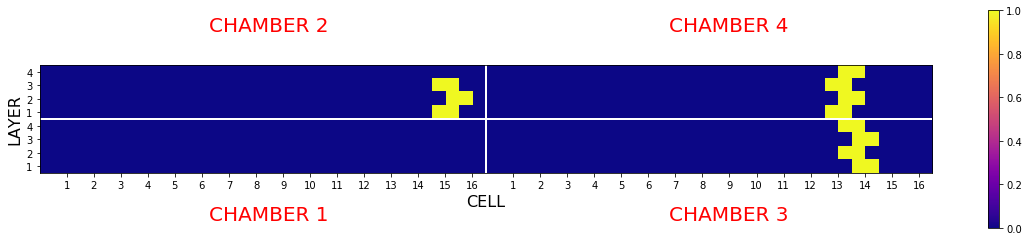

In [74]:
show_event(events, 1)

### Plot the distribution of Drift Times
To compute the drift time we easily do:
$$ t = t_{R}-t_0$$
where $t_R$ is the recorded time by each cell.

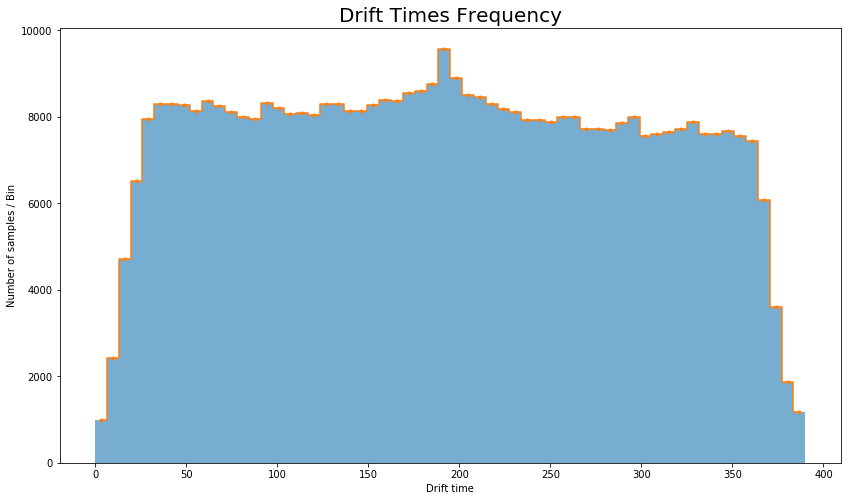

In [75]:
# Select hits where position is different from 0
events_drift = events[events['POSITION']!=0]
# Get all drift times
drift_times = events_drift['TIME_NS']-events_drift['t0']

# Drift Times Frequency
figure = plt.figure(figsize=(14,8))
ax = figure.add_subplot(111)
number_bins = 60
y, edges, bins = ax.hist(drift_times, bins = number_bins, label='Drift Times Frequency', alpha=0.6)
ax.set_ylabel("Number of samples / Bin")
ax.set_xlabel("Drift time")
ax.set_title("Drift Times Frequency", fontsize=20)
mean_point = (edges[1:] + edges[:-1])/2
ax.errorbar(mean_point, y, yerr = y**-0.5, marker = '.', drawstyle = 'steps-mid', label = 'error')

plt.show()

### Plot of the Dataframe
Graphical visalization of all the trajectory of the particels.

Number of total hits detected: 1204224
Number of hits belonging to orbit marked by trigger 139: 58.63203191432823 %
Number of events detected using the trigger: 93733


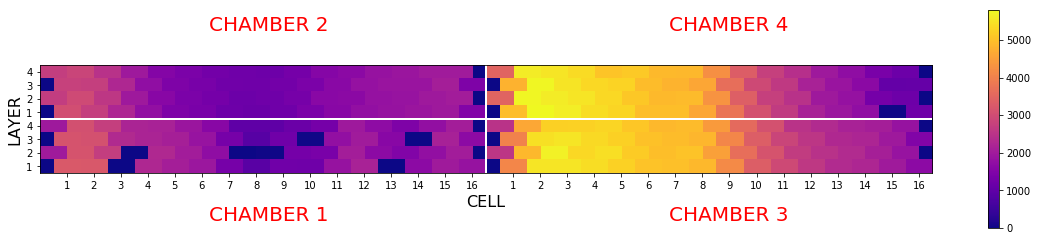

In [76]:
# Visualize all the hit from orbits marked by trigger 139
print('Number of total hits detected:', data[data['TDC_CHANNEL']<129].shape[0])
print('Number of hits belonging to orbit marked by trigger 139:', events.shape[0]/data[data['TDC_CHANNEL']<129].shape[0]*100,"%")
print('Number of events detected using the trigger:', len(event_number))

show_mat(events)

Number of hits which show a legit calculated position: 37.26325002657313 %


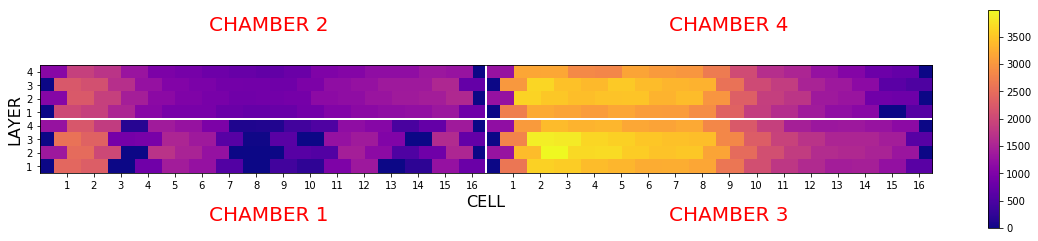

In [77]:
# Visualize only hit with a legit calculated position
print('Number of hits which show a legit calculated position:', events[events['POSITION']!=0].shape[0]/data[data['TDC_CHANNEL']<129].shape[0]*100,"%")

show_mat(events[events['POSITION']!=0])

### Plot of the Hits per Event

Now we plot the Histogram of the number of hits per event. We willconsider all the hits belonging to the same triggered orbit.

In [78]:
# Group the events by event number
grouped_ev_num = events.groupby('EVENT_NUMBER')

# Create a new list containing the number of hits per event
hits_per_event = []

# For every event count the number of hits (i.e. return the lenght of the array containing the hits of a certain event)
for i in grouped_ev_num.groups.keys():
    hits_per_event.append(len(np.array(grouped_ev_num.groups[i])))
hits_per_event = np.array(hits_per_event)

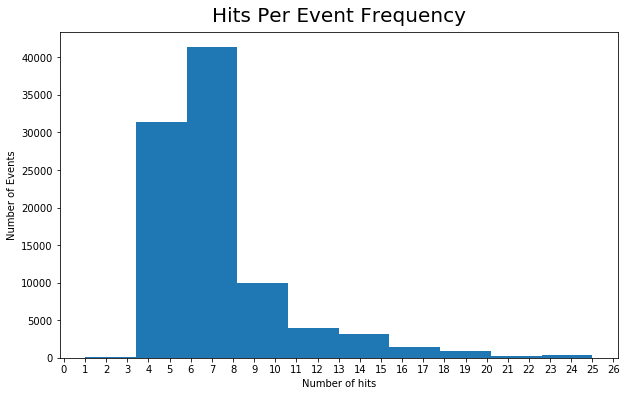

In [79]:
# Plot the distribution of Hits/Event
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_major_locator(MultipleLocator(1.000))
ax.set_title("Hits Per Event Frequency", fontsize=20, verticalalignment='bottom')
ax.set_xlabel('Number of hits')
ax.set_ylabel('Number of Events')
ax.hist(hits_per_event[hits_per_event<=25], bins=10);

## PART 2
Now we have to repeat the previous computation without the help of the external trigger 139, so we restart from the dataframe 'data'. To find the events we can use the orbits, the previous pattern and the mean trigger equation.

In [80]:
# Remove unreal hit rows and sort the dataframe
data = data[data['TDC_CHANNEL']<129]
total_hits = data.shape[0]
data = data.sort_values(by = ['ORBIT_CNT','CHAMBER','LAYER'])

# Make three shifted copy of the LAYER, TIME_NS, CELL and of CHAMBER
data['LAYER_1'] = data['LAYER'].shift(-1)
data['LAYER_2'] = data['LAYER'].shift(-2)
data['TIME_NS_1'] = data['TIME_NS'].shift(-1)
data['TIME_NS_2'] = data['TIME_NS'].shift(-2)
data['CELL_1'] = data['CELL'].shift(-1)
data['CELL_2'] = data['CELL'].shift(-2)
data['CHAMBER_1'] = data['CHAMBER'].shift(-1)
data['CHAMBER_2'] = data['CHAMBER'].shift(-2)

# There is a constrains on Chambers, which must be always the same
mask_pattern_chamber = (data['CHAMBER'] == data['CHAMBER_1']) & (data['CHAMBER'] == data['CHAMBER_2'])

# There is also a constrains on cell, which must be applied for every pattern
# The sucessive cell hit number has to differ at most by one from the previous cell number (1->2 ok, 6->5 ok, 1->3 no)
mask_pattern_cell_123 = ((data['CELL_1']-data['CELL'])>=0 & (abs(data['CELL_1']-data['CELL'])<=1)) & (((data['CELL_2']-data['CELL_1'])<=0) & (abs(data['CELL_2']-data['CELL_1'])<=1))
mask_pattern_cell_234 = ((data['CELL_1']-data['CELL'])<=0 & (abs(data['CELL_1']-data['CELL'])<=1)) & (((data['CELL_2']-data['CELL_1'])>=0) & (abs(data['CELL_2']-data['CELL_1'])<=1))

# Search pattern to get the real t0
mask_pattern_123 = (data['LAYER']==1) & (data['LAYER_1']==2) & (data['LAYER_2']==3)
mask_pattern_234 = (data['LAYER']==2) & (data['LAYER_1']==3) & (data['LAYER_2']==4)

# Compute final mask
mask_pattern = ((mask_pattern_123 & mask_pattern_cell_123) | (mask_pattern_234 & mask_pattern_cell_234)) & mask_pattern_chamber


# Apply the Talete's Theorem for t0 to the patterns
data.loc[mask_pattern, 't0'] = (data['TIME_NS'] + data['TIME_NS_2'] + 2*data['TIME_NS_1'] - 2*Tmax)/4

# Populate values of adiacent cell (according to the choosen pattern)
data = data.fillna(0)
mask_pattern_time = data['t0']!=0
data.loc[mask_pattern_time.shift(1).fillna(False), 't0'] = data['t0'].shift(1)
data.loc[mask_pattern_time.shift(2).fillna(False), 't0'] = data['t0'].shift(2)
data = data.fillna(0)

# Compute the position
data.loc[data['t0']!=0,'POSITION'] = (data['TIME_NS'] - data['t0'])*Vd
data = data.fillna(0)

# Now we have to filter false event, which can be caused by noise
# So we drop the rows with an unexpected result: such as Position bigger than 21 mm or smaller than 0 mm
data.loc[(data['POSITION']<0) | (data['POSITION']>=21), ['POSITION','t0']] = 0

data = data[data['POSITION']!=0]

data.head(5)

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS,LAYER,CHAMBER,CELL,LAYER_1,LAYER_2,TIME_NS_1,TIME_NS_2,CELL_1,CELL_2,CHAMBER_1,CHAMBER_2,t0,POSITION
2,1,0,124,1933476838,2037,18,50940.000000,1,2,15,2.0,3.0,50871.666667,50932.500000,16.0,15.0,2.0,2.0,50708.958333,12.440705
0,1,0,126,1933476838,2034,26,50871.666667,2,2,16,3.0,1.0,50932.500000,80956.666667,15.0,14.0,2.0,3.0,50708.958333,8.761218
1,1,0,123,1933476838,2037,9,50932.500000,3,2,15,1.0,2.0,80956.666667,80622.500000,14.0,14.0,3.0,3.0,50708.958333,12.036859
7,1,1,56,1933476838,3238,8,80956.666667,1,3,14,2.0,3.0,80622.500000,80950.000000,14.0,14.0,3.0,3.0,80592.916667,19.586538
3,1,1,54,1933476838,3224,27,80622.500000,2,3,14,3.0,4.0,80950.000000,80615.833333,14.0,14.0,3.0,3.0,80592.916667,1.592949


In [81]:
# Recreate the final events DataFrame
# Map obit values to a range of int
grouped_orbit = data.groupby('ORBIT_CNT')
# Search all orbits
orbits = list(grouped_orbit.groups.keys())
# Create increasing number list for the events
event_number = np.arange(1, len(orbits)+1)
# Create the map
event_map = dict(zip(orbits, event_number))
# Map values
orbit_to_map = data['ORBIT_CNT']
orbit_mapped = orbit_to_map.map(event_map)
data['EVENT_NUMBER'] = orbit_mapped

# Final DataFrame
events_final = data[['EVENT_NUMBER','ORBIT_CNT','CHAMBER','LAYER','CELL','POSITION']]
events_final.set_index(['EVENT_NUMBER','ORBIT_CNT','CHAMBER','LAYER'], inplace=True)
events_final.sort_index(inplace=True)
events_final.head(10)

CELL   POSITION
EVENT_NUMBER ORBIT_CNT  CHAMBER LAYER                 
1            1933476838 2       1        15  12.440705
                                2        16   8.761218
                                3        15  12.036859
                        3       1        14  19.586538
                                2        14   1.592949
                                3        14  19.227564
                                4        14   1.233974
                        4       1        13   8.222756
                                2        14  12.485577
                                3        13   8.806090

Show the cell alingment inside an event

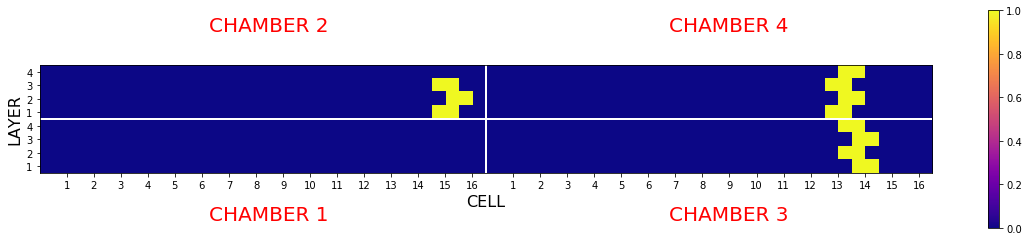

In [82]:
show_event(events, 1)

### Plot the distribution of Drift Times

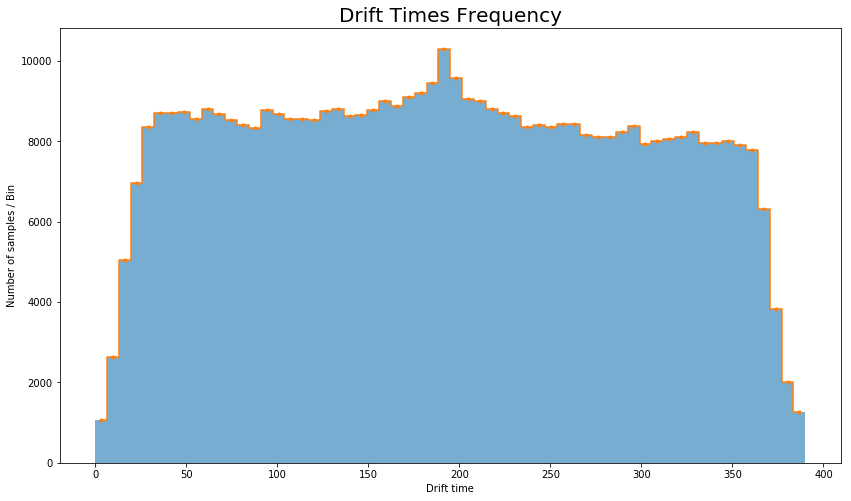

In [27]:
# Select hits where position is different from 0
events_drift = data
# Get all drift times
drift_times = events_drift['TIME_NS']-events_drift['t0']

# Drift Times Frequency
figure = plt.figure(figsize=(14,8))
ax = figure.add_subplot(111)
number_bins = 60
y, edges, bins = ax.hist(drift_times, bins = number_bins, label='Drift Times Frequency', alpha=0.6)
ax.set_ylabel("Number of samples / Bin")
ax.set_xlabel("Drift time")
ax.set_title("Drift Times Frequency", fontsize=20)
mean_point = (edges[1:] + edges[:-1])/2
ax.errorbar(mean_point, y, yerr = y**-0.5, marker = '.', drawstyle = 'steps-mid', label = 'error')

plt.show()

### Plot of the Dataframe

Number of hit belongig to an event: 39.41201969068878 %
Number of events detected using the trigger: 93514


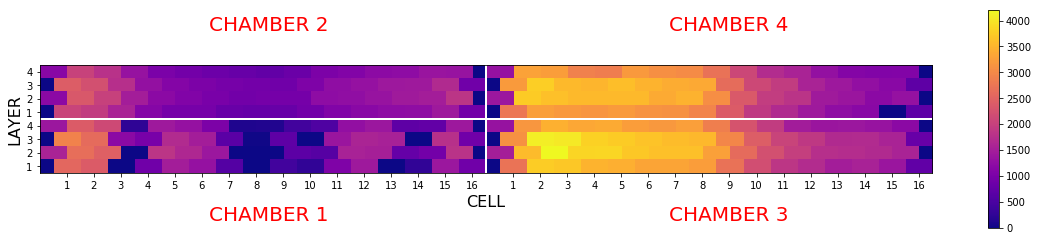

In [28]:
print('Number of hit belongig to an event:', data.shape[0]/total_hits*100,"%")
print('Number of events detected using the trigger:', len(event_number))

show_mat(data)

### Plot of the Hits per Event

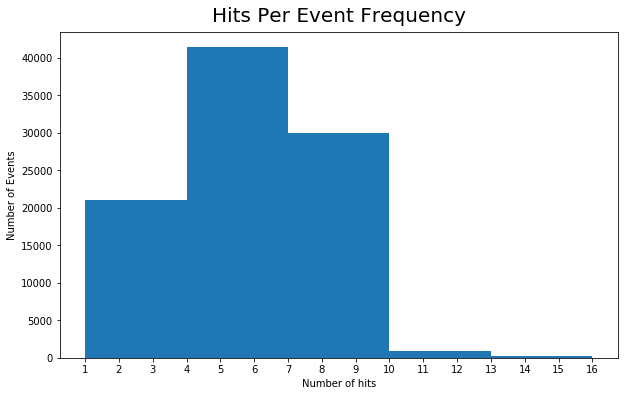

In [37]:
# Group the events by event number
grouped_ev_num = data.groupby('EVENT_NUMBER')

# Create a new list containing the number of hits per event
hits_per_event = []

# For every event count the number of hits (i.e. return the lenght of the array containing the hits of a certain event)
for i in grouped_ev_num.groups.keys():
    hits_per_event.append(len(np.array(grouped_ev_num.groups[i])))
hits_per_event = np.array(hits_per_event)

# Plot the distribution of Hits/Event
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1)
ax.xaxis.set_major_locator(MultipleLocator(1.000))
ax.set_title("Hits Per Event Frequency", fontsize=20, verticalalignment='bottom')
ax.set_xlabel('Number of hits')
ax.set_ylabel('Number of Events')
ax.hist(hits_per_event[hits_per_event<=25], bins=5);

This last result is not surpising: the majority of the events will have 3,4 and 8 hits per events, infact we are searchig patterns with 3 or 4 elements.